# Modeling Extremes - Numpyro Pt 1

In [1]:
import pandas as pd
from scipy.stats import genextreme
import numpy as np
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt
import seaborn as sns
import numpyro
from pyextremes import get_extremes
from pyextremes.plotting import plot_extremes
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data

In [2]:
data_url = "https://raw.githubusercontent.com/georgebv/pyextremes-notebooks/master/data/battery_wl.csv"

data = pd.read_csv(data_url, index_col=0, parse_dates=True).squeeze()
data.describe()

count    809903.000000
mean         -0.119026
std           0.533992
min          -2.122000
25%          -0.558000
50%          -0.111000
75%           0.316000
max           3.417000
Name: Water Elevation [m NAVD88], dtype: float64

## Clean Data

In [3]:
# sort ascending
data = data.sort_index(ascending=True)
# change type
data = data.astype(float)
# drop all nana
data = data.dropna()
# select start time - 1925
data = data.loc[pd.to_datetime("1925"):]
# rescale time
data = data  - (data.index.array - pd.to_datetime("1992")) / pd.to_timedelta("365.2425D") * 2.87e-3

data.describe()

count    796751.000000
mean         -0.063809
std           0.526933
min          -2.081901
25%          -0.498731
50%          -0.058581
75%           0.373429
max           3.357218
Name: Water Elevation [m NAVD88], dtype: float64

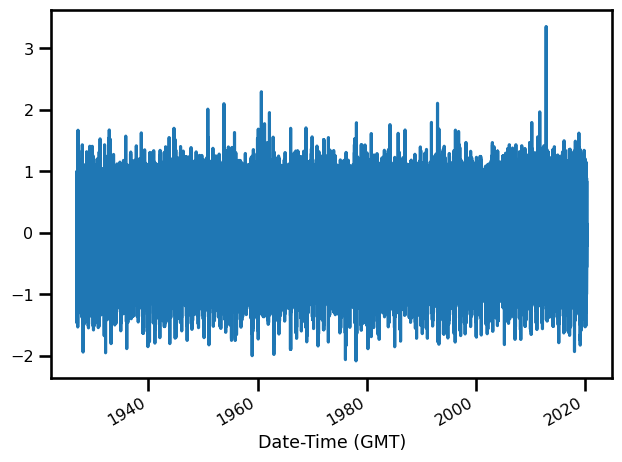

In [4]:
fig, ax = plt.subplots()

data.plot(ax=ax)

plt.tight_layout()
plt.show()

## Extremes

In [5]:
extremes_method = "BM"
block_size = "365.2425D"
extremes_type = "high"
extremes = get_extremes(
    data, 
    method=extremes_method,
    extremes_type=extremes_type, 
    block_size=block_size,
)

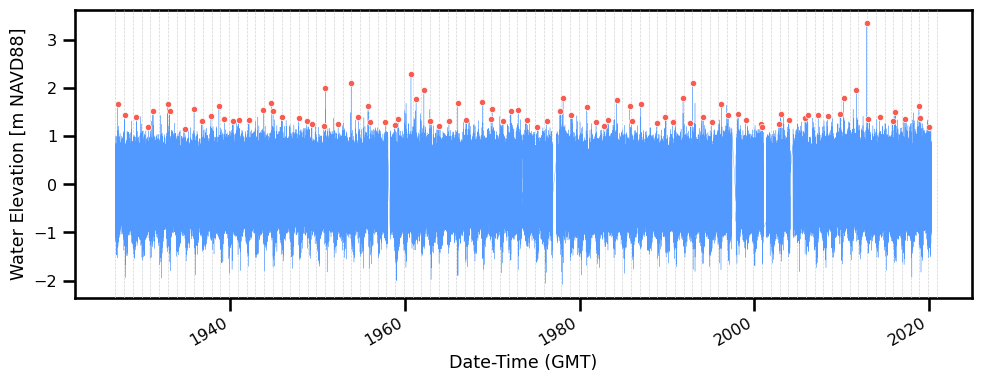

In [6]:
fig, ax = plt.subplots(figsize=(10,4))

plot_extremes(
    ax=ax,
    ts=data,
    extremes=extremes,
    extremes_method=extremes_method,
    extremes_type=extremes_type, 
    block_size=block_size,
)

plt.tight_layout()
plt.show()

## Model

### Prior & Likelihood

In [7]:
import jax
import jax.random as jrandom
import jax.numpy as jnp
from jaxtyping import Array, Float
from tensorflow_probability.substrates.jax import distributions as tfd

def model(y: Float[Array, "N"]=None):
    # model parameters
    loc = numpyro.param("loc", init_value=0.0)
    scale = numpyro.param("scale", init_value=1.0)
    concentration = numpyro.param("concentration", init_value=1.0)
    # likelihood
    
    numpyro.sample("obs", tfd.GeneralizedExtremeValue(loc, scale, concentration), obs=y)

### Inference

In [8]:
def guide(y):
    pass

In [9]:
from numpyro.infer import Predictive, SVI, Trace_ELBO
optimizer = numpyro.optim.Adam(step_size=0.0005)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
num_steps = 3_000
y = extremes.values
svi_result = svi.run(rng_key=jrandom.PRNGKey(0), num_steps=num_steps, y=y)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2572.68it/s, init loss: 208.4142, avg. loss [2851-3000]: -18.0040]


### Training

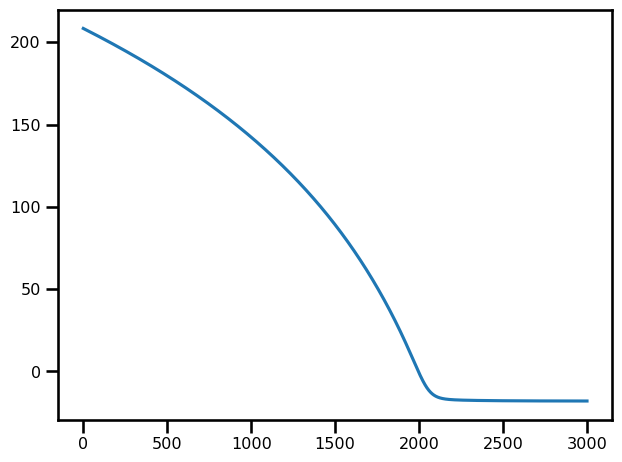

In [10]:
fig, ax = plt.subplots()
ax.plot(svi_result.losses)
plt.tight_layout()
plt.show()

In [11]:
svi_result.params

{'concentration': Array(0.25078467, dtype=float32),
 'loc': Array(1.3540868, dtype=float32),
 'scale': Array(0.14644441, dtype=float32)}

### Params

In [12]:
c = svi_result.params["concentration"]
loc = svi_result.params["loc"]
scale = svi_result.params["scale"]

In [13]:
print("Parameters (MLE):")
print(f"Shape - ξ: {c:.4f}")
print(f"Loc   - μ: {loc:.4f}")
print(f"Scale - σ: {scale:.4f}")

Parameters (MLE):
Shape - ξ: 0.2508
Loc   - μ: 1.3541
Scale - σ: 0.1464


## Return Period

In [14]:
import numpy as np
from scipy.stats import genextreme

return_periods = np.logspace(-1, 3,20)

model = tfd.GeneralizedExtremeValue(loc=loc, scale=scale, concentration=c)
return_levels = model.quantile(1-1/return_periods)

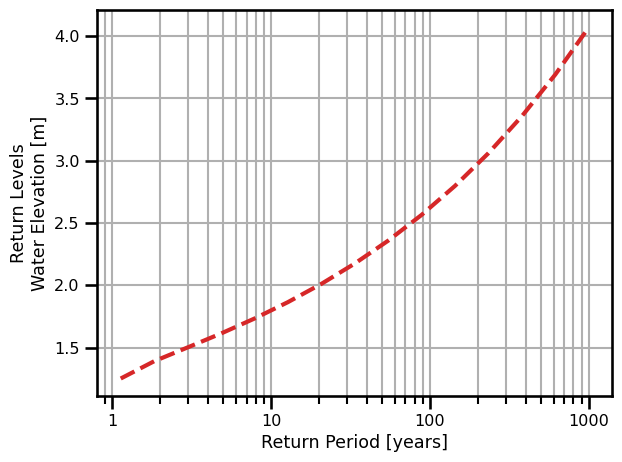

In [15]:
fig, ax = plt.subplots()

ax.plot(return_periods, return_levels, linestyle="--", linewidth=3, color="tab:red")

ax.set(
    xlabel="Return Period [years]",
    ylabel="Return Levels\nWater Elevation [m]",
    xscale="log",
)
# format log scale labels
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)

plt.grid(which="both", visible=True)
plt.tight_layout()
plt.show()